# Doc2Vec

In [33]:
import collections
import glob
from itertools import chain
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json

import nltk
import nltk.data
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sentence_parser = nltk.data.load('tokenizers/punkt/english.pickle')

%matplotlib inline
np.random.seed(1)

In [34]:
fp = open("articledata.json")
d = json.load(fp)
l = []
for url in d.keys():
    x = {'text': d[url]}
    if d[url]:
        x['url'] = url
        x['label'] = 'Art'
        l.append(x)
df = pd.DataFrame(l)
df

,label,text,url
0,Art,This article is about the academic discipline ...,https://en.wikipedia.org/wiki/Art_history
1,Art,"If you're seeing this message, it means we're ...",https://www.khanacademy.org/humanities/art-his...
2,Art,"If you're seeing this message, it means we're ...",https://www.khanacademy.org/humanities/art-his...
3,Art,"Art history, also called art historiography, h...",https://www.britannica.com/art/art-history
4,Art,"""Why study art history when there are many oth...",https://www.iesa.edu/paris/news-events/art-his...
5,Art,The Definition of Islamic Art\n\nThe objective...,https://apcentral.collegeboard.org/courses/ap-...
6,Art,Building a Context\n\nArchitecture can be a ch...,https://apcentral.collegeboard.org/courses/ap-...
7,Art,"The art of Africa covers a broad region, of co...",http://www.arthistory.net/african-art/


In [35]:
words = []
for f in df['text']:
    words.append(f)

words = list(chain.from_iterable(words))
words = ''.join(words)[:-1]
sentences = words.split('\n')
clean_sentences = [];

for s in sentences:
    for x in s.split("."):
        word_count = len(x.split(" "))
        if word_count > 5:
            clean_sentences.append(x)
            
sentences = clean_sentences

In [36]:
vocabulary_size = 40000

def build_dataset(sentences):
    words = ''.join(sentences).split()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    unk_count = 0
    sent_data = []
    for sentence in sentences:
        data = []
        for word in sentence.split():
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
        sent_data.append(data)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return sent_data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:2])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 103], ('the', 560), ('of', 469), ('and', 328), ('to', 216)]
Sample data [[40, 537, 8, 59, 1, 361, 95, 2, 6, 12], [73, 16, 538, 2, 1, 12, 2, 6, 1030, 362, 49, 2, 6]]


## Tensorflow Model

In [37]:
skip_window = 3
instances = 0

# Pad sentence with skip_windows
for i in range(len(data)):
    data[i] = [vocabulary_size]*skip_window+data[i]+[vocabulary_size]*skip_window

# Check how many training samples that we get    
for sentence  in data:
    instances += len(sentence)-2*skip_window
print(instances)    

9712


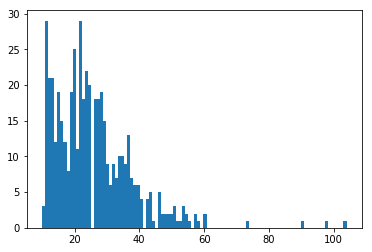

In [38]:
sent_len = np.array([len(d) for d in data])
plt.hist(sent_len,100)
plt.show()

In [39]:
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)
doc = np.zeros((instances,1),dtype=np.int32)

k = 0
for doc_id, sentence  in enumerate(data):
    for i in range(skip_window, len(sentence)-skip_window):
#         buffer = sentence[i-skip_window:i+skip_window+1]
#         labels[k] = sentence[i]
#         del buffer[skip_window]
#         context[k] = buffer
#         doc[k] = doc_id
#         k += 1
        context[k] = sentence[i-skip_window:i+skip_window+1] # Get surrounding words
        labels[k] = sentence[i] # Get target variable
        doc[k] = doc_id
        k += 1
        
context = np.delete(context,skip_window,1) # delete the middle word        
        
shuffle_idx = np.random.permutation(k)
labels = labels[shuffle_idx]
doc = doc[shuffle_idx]
context = context[shuffle_idx]

In [40]:
batch_size = 256
context_window = 2*skip_window
embedding_size = 50 # Dimension of the embedding vector.
softmax_width = embedding_size # +embedding_size2+embedding_size3
num_sampled = 5 # Number of negative examples to sample.
sum_ids = np.repeat(np.arange(batch_size),context_window)

len_docs = len(data)

graph = tf.Graph()

with graph.as_default(): # , tf.device('/cpu:0')
    # Input data.
    train_word_dataset = tf.placeholder(tf.int32, shape=[batch_size*context_window])
    train_doc_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    segment_ids = tf.constant(sum_ids, dtype=tf.int32)

    word_embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    word_embeddings = tf.concat([word_embeddings,tf.zeros((1,embedding_size))],0)
    doc_embeddings = tf.Variable(tf.random_uniform([len_docs,embedding_size],-1.0,1.0))

    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, softmax_width],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_words = tf.segment_mean(tf.nn.embedding_lookup(word_embeddings, train_word_dataset),segment_ids)
    embed_docs = tf.nn.embedding_lookup(doc_embeddings, train_doc_dataset)
    embed = (embed_words+embed_docs)/2.0#+embed_hash+embed_users

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases, train_labels, 
                                         embed, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(doc_embeddings), 1, keep_dims=True))
    normalized_doc_embeddings = doc_embeddings / norm

In [41]:
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_doc_data = doc[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_doc_data = np.vstack([doc[data_idx:instances],doc[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data, batch_doc_data

In [42]:
num_steps = 1000001
step_delta = int(num_steps/20)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_word_data, batch_doc_data\
        = generate_batch(batch_size)
        feed_dict = {train_word_dataset : np.squeeze(batch_word_data),
                     train_doc_dataset : np.squeeze(batch_doc_data),
                     train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % step_delta == 0:
            if step > 0:
                average_loss = average_loss / step_delta
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    # Get the weights to save for later
#     final_doc_embeddings = normalized_doc_embeddings.eval()
    final_word_embeddings = word_embeddings.eval()
    final_word_embeddings_out = softmax_weights.eval()
    final_doc_embeddings = normalized_doc_embeddings.eval()

Initialized
Average loss at step 0: 36.700085
Average loss at step 50000: 6.756837
Average loss at step 100000: 1.659259
Average loss at step 150000: 0.714117
Average loss at step 200000: 0.396829
Average loss at step 250000: 0.266391
Average loss at step 300000: 0.203882
Average loss at step 350000: 0.175438
Average loss at step 400000: 0.158020
Average loss at step 450000: 0.148953
Average loss at step 500000: 0.143333
Average loss at step 550000: 0.140133
Average loss at step 600000: 0.137871
Average loss at step 650000: 0.136385
Average loss at step 700000: 0.134816
Average loss at step 750000: 0.134080
Average loss at step 800000: 0.132600
Average loss at step 850000: 0.131824
Average loss at step 900000: 0.130726
Average loss at step 950000: 0.130559
Average loss at step 1000000: 0.129895


In [43]:


rand_doc = np.random.randint(len_docs)
dist = final_doc_embeddings.dot(final_doc_embeddings[rand_doc][:,None])
closest_doc = np.argsort(dist,axis=0)[-4:][::-1]
furthest_doc = np.argsort(dist,axis=0)[0][::-1]

for idx in closest_doc:
    print(dist[idx][0][0])
    
print(dist[furthest_doc][0][0])    
print(sentences[176])

1.0
0.805142
0.7586118
0.74317455
0.39424738
Arnold Hauser wrote the first Marxist survey of Western Art, entitled The Social History of Art


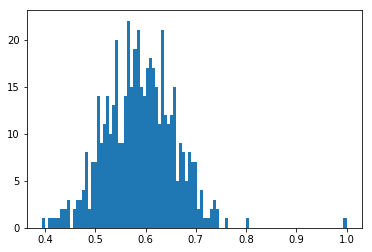

In [44]:
plt.hist(dist,100)
plt.show()

In [45]:
sentences[rand_doc]

' Museum studies, including the history of museum collecting and display, is now a specialized field of study, as is the history of collecting'

In [46]:
sentences[closest_doc[1][0]]

'Museum studies and collecting [ edit ]'

In [47]:
sentences[closest_doc[2][0]]

' Chicago: University of Chicago Press'

In [48]:
sentences[closest_doc[3][0]]

'Feminist art history [ edit ]'

In [49]:
sentences[furthest_doc[0]]

' What does the difference in those materials imply? Stone can only span relatively small spaces (the Parthenon had little interior space); steel and concrete allow spatial freedom and larger interior spaces (such as classrooms)'

In [50]:
norm_vec[rand_doc].dot(norm_vec[closest_doc[1][0]])

NameError: name 'norm_vec' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dist,100)
plt.show()

## Gensim Model

In [ ]:
import gensim
from gensim.models import Doc2Vec
from multiprocessing import cpu_count

cpus = cpu_count()

In [ ]:
def read_corpus():
    for i,sentence in enumerate(words.split('\n')):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i])

train_corpus = list(read_corpus())

In [ ]:
model = Doc2Vec(dm=1, dm_concat=0, size=embedding_size, window=skip_window, 
                negative=5,hs=0, min_count=5, workers=cpus, iter=2)
model.build_vocab(train_corpus)

In [ ]:
%%time
model.train(train_corpus)

In [ ]:
closest_doc2 = model.docvecs.most_similar([model.docvecs[rand_doc]],topn=4)
for _, sim in closest_doc2:
    print(sim)

In [ ]:
sentences[rand_doc]

In [ ]:
sentences[closest_doc2[1][0]]

In [ ]:
sentences[closest_doc2[2][0]]

In [ ]:
sentences[closest_doc2[3][0]]

In [ ]:
norm_vec = np.array([vec for vec in model.docvecs])
norm_vec = norm_vec/np.sqrt(np.sum(np.square(norm_vec),axis=1,keepdims=True))

norm_vec[rand_doc].dot(norm_vec[closest_doc[1][0]])